In [ ]:
#default_exp stats.rmats

# stats.rmats

> The statistical functions needed to perform shrinkage on rMATS output.

In [ ]:
#export
import numpy
import scipy 
from matplotlib import pyplot
import seaborn
import pandas as pd
import tarfile
import scipy.stats as stats
import scipy.optimize as opt
from tqdm import tqdm
import os
from copy import deepcopy

from spliceformats.utilities import text2float,progbar,check_rMATS_type
from spliceformats.wrappers import call_ashr
from spliceformats.parsers import read_rMATS_from_tar

## Within this module, do not warn about divide by zero
warning_settings=numpy.seterr(divide='ignore', invalid='ignore')


In [ ]:
#hide
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6, 6]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Overview

To perform shrinkage of the deltaPSI estimates with `ashr` we need both estimates deltaPSI and standard errors for those estimates. rMATS, however, does not return the parameters of the fitted statistical model. Rather, it summarizes the read counts to report estimates of $\Psi_{ctrl}$, $\Psi_{exp}$ and $\Psi_{exp} - \Psi_{ctrl}$. The confidence that $|\Psi_{exp} - \Psi_{ctrl}|>0$ (see note) is summarized with a p-value. 

Rather than go through the effort of fitting a model to the data so that I can access the values of the parameters and their associated uncertainty, I want to approximate the mean and standard error of the change PSI using only the information that rMATS reports. 

(Note: The rMATS null hypothesis is not actually $|\Psi_{exp} - \Psi_{ctrl}|>0$, but rather $|\Psi_{exp} - \Psi_{ctrl}|>c$)

Let's begin by loading in some rMATS data

In [ ]:

from spliceformats.parsers import read_rMATS_from_tar
from spliceformats.readMATS import rmatsResults

data=rmatsResults('00_data/ENCFF602CHO.tar.gz')
df=data.SE.df

In [ ]:
#export
def estimate_alpha_beta(IJC,SJC, axis=1):
    """Infers the population distribution of inclusion read frequencies by fitting a \
    beta-binomial distribution to observed read counts.
    
    ****
    **Arguments:**
    
    `IJC`: An array of inclusion-junction counts, where the first axis indexes splicing events \
    and the second axis indexes replicates.
    
    `SJC`: An array of exclusion/skipped junction counts, where the first axis indexes splicing events \
    and the second axis indexes replicates.
    
    ****
    **Returns**: 
    
    `alpha`, beta` (float): The MLE parameters of the fitted beta-binomial distribution
    
    `success` (bool): Whether optimization succeeded
    """
    k=IJC.sum(axis)
    N=IJC.sum(axis)+SJC.sum(axis)
    func= lambda x:-numpy.arcsinh( scipy.stats.betabinom.logpmf(k, N, a=2.**x[0], b=2.**x[1]).sum())
    fit=opt.minimize(func, numpy.zeros(2))
    if fit.success==False:
        Warning("Optimization did not converge when fitting the beta-binomial to the read counts ")
    return 2.**fit.x[0], 2.**fit.x[1], fit.success
        
    
    

Warning('Optimization did not converge when fitting the beta-binomial to the read counts ')

In [ ]:
#export
def estimate_PSI(IJC, SJC, offset=[],incformlen=[], skipformlen=[],
                   mean=True, axis=1,
                   alpha=1, beta=1,  empirical_bayes=False, 
                   min_read=50, verbose=False, use_backup_estimator=False):
    """
    Computes an estimate of PSI based on beta-binomial model of the read counts.
    ****
    **Arguments:**
    
    `IJC`: An array of inclusion-junction counts, where the first axis indexes splicing events \
    and the second axis indexes replicates.
    
    `SJC`: An array of exclusion/skipped junction counts, where the first axis indexes splicing events \
    and the second axis indexes replicates.
    
    `offset`: The log of inclusion form length divided by exclusion form length. Note: \
    If this is not provided, then both incformlen and skipformlen must be provided \
    so the offset can be computed. \
    
    `incformlen`, `skipformlen` : Arrays hold the length of the inclusion and exclusion forms
    
    `alpha`, `beta` (float >= 0): The alpha and beta parameters of the Beta prior on the IJC/(IJC+EJC) read ratio. \
    Can also be thought of as pseudocounts added to the read counts. alpha=1, beta=1 corresponds to a uniform prior
    
    `empirical_bayes`: whether to use a two-step approximation to a hierarchical model. First estimates the PSI of each \
    splicing event, then fits a beta distribution to this, and reestimates PSI using the alpha and beta parameters from the\
    beta fit as the priors
    
    `min_read`: When using empirical Bayes, filter out events with fewer reads than this when fitting the beta distribution. Only \
    applies when estimating the Beta prior.
    
    ****
    **Returns**: `PSI` (array)"""
    
    
#     assert ((len(offset)!=0) or (len(incformlen)!=0 & len(skipformlen)!=0))
    
    if len(offset)==0:
        offset=numpy.log(numpy.array(skipformlen, float)/
                         numpy.array(incformlen, float))

    if mean==True: 
        IJC_pseudo=IJC.sum(axis)+alpha
        SJC_pseudo=SJC.sum(axis)+beta
    else:
        IJC_pseudo=IJC+alpha
        SJC_pseudo=SJC+beta
    
    if len(IJC_pseudo.shape)>1:
        offset=offset[:,None]    
    raw_psi=(IJC_pseudo) /(IJC_pseudo+SJC_pseudo)
    raw_phi=scipy.special.logit(raw_psi)
    phi=raw_phi+offset
    psi=scipy.special.expit(phi)
    
    if empirical_bayes==True:
        alpha_est, beta_est, success=estimate_alpha_beta(IJC, SJC, axis)
        if success==False and use_backup_estimator==True:
            raise(Warning(f"Fitting a beta-binomial failed. Inferring alpha and beta by only modelling eoxns with >{min_read} read counts."))
        
            total_counts=IJC.mean(axis)+SJC.mean(axis)
            filter_ind=total_counts>=min_read
            alpha_est, beta_est, loc,scale=scipy.stats.beta.fit(psi[filter_ind], floc=0, fscale=1)
        psi=estimate_PSI(IJC, SJC, offset,
                   mean=mean, axis=axis,
                   alpha=alpha_est, beta=beta_est,  empirical_bayes=False)
    return psi
    

In [ ]:
PSI1=estimate_PSI(data.SE.IJC[0],data.SE.SJC[0],
                  incformlen=data.SE.len_incform ,skipformlen=data.SE.len_excform,
                  empirical_bayes=True)

Note: It should not generally be necessary to actually call `estimate_PSI` and all of the examples below are mostly illustrative. When rMATS output is loaded using `read_rmats` PSI estimates are returned as part of the output.

### How the rMATS inclusion levels are computed

The inclusion levels reported by rMATS are transformations of the observed read counts, rather than more formal parameter estimates. If $IJC_k$ and $SJC_k$ are the number of reads supporting the inclusion and exclusion forms of the transcript in replicate $k$, then the fraction of reads derived from inclusion form in that replicate is 

$$\hat{p}_k = \frac{ IJC_k}{ IJC_k + SJC_k }$$

This fraction of IJC reads, however, isn't PSI because the amount of the sequence supporting the inclusion isoform will generally differ from the amount of sequence supporting the exclusion isoform. In the case of the skipped exon, there will generally be twice as much sequence supporting the inclusion-form than the skipped-formed. So we need to correct for this, which we can do as follows

$$\hat{\Psi}_{cond,k}=\frac {\hat{p}_{cond,k}L_S}{\hat{p}_{cond,k}L_S+(1-\hat{p}_{cond,k})L_I}$$


We work through an example of this calculation. Let's look at the first row of this output file:

In [ ]:
df.iloc[0]

ID                                 12823
GeneID                ENSG00000131504.11
geneSymbol                        DIAPH1
chr                                 chr5
strand                                 -
exonStart_0base                140967790
exonEnd                        140967817
upstreamES                     140966608
upstreamEE                     140966764
downstreamES                   140998364
downstreamEE                   140998566
ID.1                               12823
IJC_SAMPLE_1                         7,0
SJC_SAMPLE_1                       74,29
IJC_SAMPLE_2                       40,24
SJC_SAMPLE_2                         3,6
IncFormLen                           126
SkipFormLen                          100
PValue                               0.0
FDR                                  0.0
IncLevel1                       0.07,0.0
IncLevel2                     0.914,0.76
IncLevelDifference                -0.802
Name: 0, dtype: object

In condition 1, replicate 1, there are 7 IJC reads and 74 SJC reads. So $\hat{p}= \frac{7}{7+74} =.086$. But the inclusion form has 126 nucleotides versus 100 for the skipped form, so $\hat{\Psi}=\frac{.086*100}{.086*100+ (1-.086)*126}=.07$, which is what rMATS reports. Here are the calculation in code:

In [ ]:
p=7/(7+74)
print (f"Inclusion read fraction = {p}")
psi=p*100/(p*100+(1-p)*126)
print (f"\nPSI estimate = {psi}")

Inclusion read fraction = 0.08641975308641975

PSI estimate = 0.06983240223463687


We can use the `estimate_PSI` function to compute this as well (though, in most cases, it's not necessary to call this function):

In [ ]:
print (estimate_PSI(data.SE.IJC[0][0,:],
                    data.SE.SJC[0][0,:],
                    incformlen=data.SE.len_incform[0] ,
                    skipformlen=data.SE.len_excform[0], 
                    mean=False,
                    alpha=0,beta=0)[0])

0.06983240223463685


In many cases, this will be sufficient for downstream analyses, but it does pose some problems. For example, consider replicate 2. Here, there are 0 IJC reads and 29 SJC reads. So $\hat{p}= \frac{0}{0+29} =0$. Because $\hat{p}=0$, so also $\hat{\Psi}=0$, which is what rMATS reports. Is this evidece that the true value of PSI in that replicate is 0%? No. The absence of IJC reads is not strong evidence for $\Psi=0$ if the total read count is relatively small. Further, even if the total read count were large, $IJC=0$ only the demonstrates that PSI is quite small, probably less than $\frac{1}{IJC+SJC}$. 

The presence of $\hat{\Psi}=0$ and $\hat{\Psi}=1$ is further problematic because the actually rMATS model works with log-odds of $\Psi$, so we're going to need to work with logit transformations fo $\Psi$:

$$\Phi=ln \frac{\Psi}{1-\Psi}$$

which is not defined for 0 or 1.

### Resolving this with pseudocounts

A simple way to resolve this is to add pseudocounts to the observed read counts that prevent the numerator or denominator from ever equalling zero, but which only substantially affect the estimated PSI value if the total read counts are small.  Practically, these prevent the estimated PSI from being close to zero ore one unless there are a sufficient number of reads to feel confident that we didn't just miss all of the IJC or SJC reads due to sampling variation. So, instead we'll estimate $\hat{p}$ as

$$\hat{p}_k = \frac{ IJC_k+1}{ IJC_k + SJC_k +2}$$

Further, I want to estimate PSI for each condition rather than for each replicate, so I will instead compute

$$\hat{p} = \frac{1 + \sum_k IJC_k}{2+ \sum_k (IJC_k + SJC_k) }$$

summing over all replicates in a given condition. Both of these choices can be justified from a Bayesian perspective, but for now let's compare them to the rMATS output.

In [ ]:
p=(7+1)/(7+74+2)
print (p)
psi=p*100/(p*100+(1-p)*126)
print (psi)

0.0963855421686747
0.07804878048780488


In [ ]:
p=(0+1)/(0+29+2)
print (p)
psi=p*100/(p*100+(1-p)*126)
print (psi)

0.03225806451612903
0.02577319587628866


In [ ]:
PSI1=estimate_PSI(data.SE.IJC[0],data.SE.SJC[0],
                  incformlen=data.SE.len_incform ,skipformlen=data.SE.len_excform,
                  mean=True)

PSI2=estimate_PSI(data.SE.IJC[1],data.SE.SJC[1],
                  incformlen=data.SE.len_incform ,skipformlen=data.SE.len_excform, 
                  mean=True)

PSI1_rmat=estimate_PSI(data.SE.IJC[0],data.SE.SJC[0],
                       incformlen=data.SE.len_incform ,skipformlen=data.SE.len_excform, 
                       mean=True,
                      alpha=0, beta=0)
PSI2_rmat=estimate_PSI(data.SE.IJC[1],data.SE.SJC[1],
                       incformlen=data.SE.len_incform ,skipformlen=data.SE.len_excform, mean=True,
                      alpha=0, beta=0)

In [ ]:
PSI1[0]

0.057537399309551214

If we just plot the original and pseudocount corrected PSI estimates against each other, for most part they, match, except where the rMATS estimate was 0 or 1, producing an odd backwards N shape:

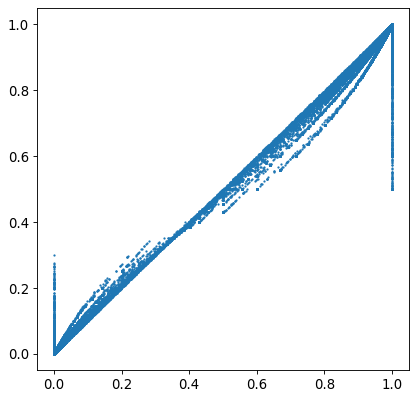

In [ ]:
pyplot.scatter( PSI1_rmat,PSI1, s=1)

This is because the pseudocount correction most strongly impacts splicing events supported by few reads:

The the raw rMATs should only substantially differ from those with pseudocounts when the total read count is low:

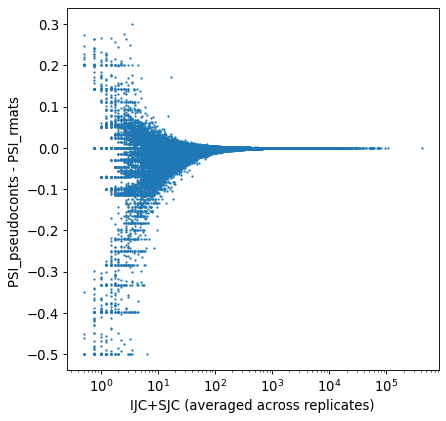

In [ ]:
pyplot.scatter( data.SE.totalreads, PSI1-PSI1_rmat, s=1)
pyplot.ylabel("PSI_pseudoconts - PSI_rmats ")
pyplot.xlabel('IJC+SJC (averaged across replicates)')
pyplot.xscale('log')

So if we only look at splicing events with more than 200 IJC+SJC reads per replicate, the two estimates should be nearly identical:

Text(0, 0.5, 'PSI1 (pseudocounts)')

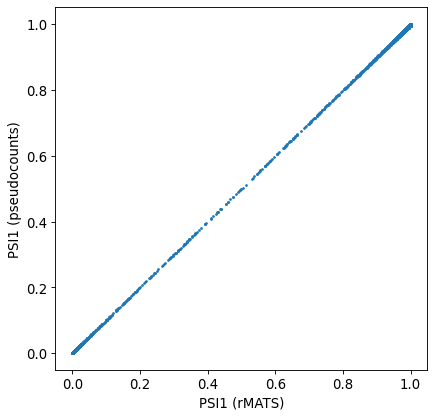

In [ ]:
total_reads=data.SE.totalreads
pyplot.scatter(PSI1_rmat[total_reads>200], PSI1[total_reads>200], s=2)
pyplot.xlabel('PSI1 (rMATS)')
pyplot.ylabel('PSI1 (pseudocounts)')

And they do. We can use these to estimate deltaPSI $\Psi_{exp}-\Psi_{ctrl}$:

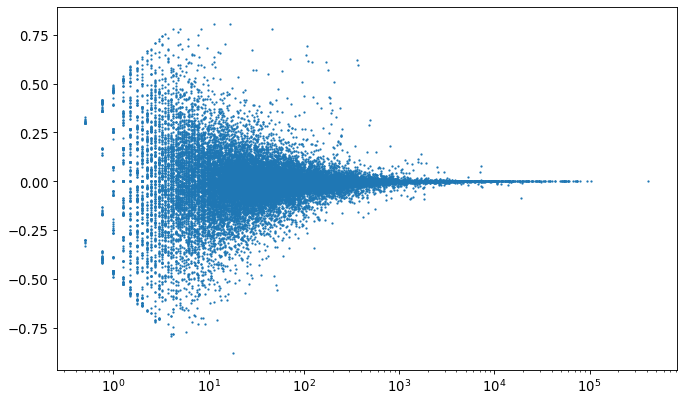

In [ ]:
dpsi=PSI2-PSI1
ax=pyplot.figure(figsize=(10,6))
pyplot.scatter( data.SE.exon_info['Total_reads'].values/4, dpsi, s=1)
pyplot.xscale('log')

### What the pseudocounts really mean

These pseudocounts can be justified from a Bayesian perspective, where they represent prior beliefs about the value of PSI. That is, *a priori* we believe that PSI might not be zero or one, so even if all or none of the observed reads support the inclusion form, those prior beliefs should pull the estimated value of PSI away from 0 and 1.

Ideally, we could work with the parameters estimated for the rMATS model, but absent that we can obtain reasonable approximations of PSI using a beta-binomial model. We can model the inclusion junction read counts as arising

$$p \sim Beta(\alpha, \beta)$$

$$IJC \sim Binomial(n=IJC+SJC, p)$$ 

Then, the posterior mean for $p$ is,
   
$$\bar{p} = E[p|IJC, SJC] = \frac{\alpha + \sum_k IJC_k}{\alpha +\beta + \sum_k (IJC_k + SJC_k) }$$
    
where $IJC_k$ is the IJC reads count from replicate $k$. So, when estimating the expected value of $p$ given the data, the parameters, $\alpha$ and $\beta$, of the prior distribution on $p$ become pseudocounts. 
  
Again, this estimated frequency of IJC reads, however, isn't PSI because the amount of the sequence supporting the inclusion isoform will generally differ from the amount of sequence supporting the exclusion isoform. In the case of the skipped exon, there will generally be twice as much sequence supporting the inclusion-form than the skipped-formed. So we need to correct for this, which we can do as follows

$$\bar{\Psi}=\frac {\bar{p}L_S}{\bar{p}L_S+(1-\bar{p})L_I}$$

where $L_I$ and $L_S$ are the number of nucleotides of sequence that support the inclusion and exclusion (skipped) forms respectively.


Using the beta-binomial to estimate the PSI values provides a small amount of shrinkage, as when the read counts are low the pseudocounts drag the PSI estimates toward the *a priori* expected value of PSI $\frac{\alpha L_I}{\alpha L_I+\beta L_S}$.

We can check how close the these estimates of dPSI are to what is reported by rMATS. Because the pseudocounts shrink the dPSI estimates somewhat when

In [ ]:
#export
def p2LR(pval):
    """This converts p-values back to the LRT test statistic
    ****
    **Arguments:** 
    
    `pval` - either a float between 0 and 1 or a numpy array of pvalues
    
    ****
    **Returns:** The LRT test-statistic"""
    maxval=pval[pval!=1].max()
    minval=pval[pval!=0].min()
    pval[pval==0]=minval
    pval[pval==1]=maxval
    q=1.-pval
    z=stats.chi2.ppf(q,1)
    inf_ind=numpy.isinf(z)
    z_max=z[~inf_ind].max()
    z[inf_ind]=z_max
    return z**.5

    
def approximate_coefficients(pval, PSI1, PSI2, c=0):
    """Works backward from the LRT p-value to approximate the mean and standard error associated with each dPSI estimate \
    on log-odds scale.
    ****
    **Arguments:**
    
    `pval` - an iterable of pvalues
    
    `PSI1` - an iterable of PSI estimates for condition 1
    
    `PSI2` - an iterable of PSI estimates for condition 2
    
    `c` - the small value of dPSI assumed by the rMATS null hypothesis
    
    ****
    **Returns:**
    
    `mean` -  the expected value of log(PSI1/PSI2)
    
    `se` - an approximation of the standard error"""
    z=p2LR(pval)
    PSI1_lod=PSI1/(1-PSI1)
    PSI2_lod=PSI2/(1-PSI2)
    mean=numpy.log(PSI1_lod/PSI2_lod)
    
    C1=(PSI2+numpy.sign(mean)*c)
    C1_lod=C1/(1-C1)
    
    
    boundary=numpy.log(C1_lod/PSI2_lod)
 
    is_valid=1*(numpy.abs(mean)>=numpy.abs(boundary))
    se=numpy.abs(mean-boundary)/z 
    se_min=numpy.min(se[se>0])
    se[se==0]=se_min
    inf_ind=numpy.isinf(se)
    se_max=se[~inf_ind].max()
    se[inf_ind]=se_max
    return mean, se

### Estimating standard errors for deltaPSI

To perform shrinkage on the deltaPSI estimates with `ashr` we need to express how uncertain we are about the extent to which the spliceform levels have changed between the two conditions.  Specifically, we need to provide a mean deltaPSI estimate and a standard deviation for each splicing event. rMATS, however, doesn't report standard errors for deltaPSI. It does, however report the p-values of a likelihood ratio test test comparing how likely the observed data are given the best deltaPSI estimate to a null model where deltaPSI is set to a small value near near zero. This provides enough information about the likelihood function to approximate it with a normal distribution, which is what we need if we're going to compute standard errors (the standard deviation only makes sense as a summary statistic if the likelihood is approximately normal). It does not make sense, however, to compute standard errors for deltaPSI itself, because deltaPSI is constrained between -1 and 1. Instead, it's more sensible to standard errors for the best estimate of difference in the log-odds of exon inclusion $\delta_i=\phi_1 - \phi_2$.

Briefly, to approximate the standard errors, we can do the following. 

1. Given rMATS the p-value for splicing event $i$, $p_i$, we'll use the Chi2 inverse cdf to identify the corresponding test statistic $\Lambda_i=-2logLR$. 

$$\Lambda_i=CDF_{\chi^2(df=1)}^{-1}(1-p_i)$$

2. This difference in likelihoods between the alternative and null models can be used to determine the standard deviation of a normal approximation of the likelihood function:

$$ \sigma_i =\frac{|\delta_\emptyset-\delta_i|}{\sqrt{\Lambda_i}}$$


### More details on the rMATS hypothesis test

The rMATS full model is simply this: deltaPSI has changed and $\delta_i$ describes how it has changed. That is if $\phi_{i, ctrl}$ is the log-odds of exon-inclusion in the control, then the log-odds of the exon-inclusion in the experimental condition is

$$\phi_{i,exp}^{full} = \phi_{i,ctrl} + \delta_i$$

Simplest null model is that deltaPSI has not changed at all

$$\phi_{i,exp}^{null} = \phi_{i,ctrl} + 0 $$

rMATS instead uses a slighly more flexible null hypothesis, asserting that deltaPSI has not changed more than some small value, $c$. In log-odds scale, I'll call this $\delta_{\emptyset}$ and the null model is

$$\phi_{i,exp}^{null} = \phi_{i,ctrl} + \delta_{\emptyset} $$

Because the null model is nested within the full model (it simply fixes the value of $\delta_i$), rMATS uses the ratio of the likelihoods as its test statistic to compute the p-value. The likelihood ratio is the probability of seeing the observed data assuming the full model is true divided by the probability of the data under the null model:

$$LR=\frac{P \left(data_{exp} | \phi_{i,exp}^{full}\right)}{P \left(data_{exp} | \phi_{i,exp}^{null}\right)}$$

The null model is missing one free parameter compared to the full model, so the ratio of the log-likelihoods can be approximated as arising from a Chi-square distribution with one degree of freedom

$$-2 log LR \sim \chi^2(=1)$$






### More details on connecting this to the standard error

Describing the uncertainty of some parameter estimate with a standard deviation essentially approximates the posterior distribution of that parameter with a normal distribution. So, to get standard errors for the change in exon-inclusion $\delta_i$, we need to approximate the likelihood of the data given $\delta_i$ with a normal distribution. We have two pieces of information available to us. First, we can estimate the most likely value of $\delta_i$, which gives us the mean of the normal distribution. 



We also have the likelihood ratio, which tells us how much more likely the data is at $\delta_i$ than at $\delta_\emptyset$. Given that we are assuming the likelihood to be a normal distribution, we can write the likelihood of the full model as

$$L^{full}=\frac{1}{\sigma_i\sqrt{2 \pi}}exp\left[-\frac{(\delta_i-\delta_i)^2}{2\sigma_i^2}\right]=\frac{1}{\sigma_i\sqrt{2 \pi}}$$

Because this evaluates the likelihood at the mode, the likelihood is entirely determined by the standard deviation. The null model, however, is the likelihood at a point away from the mode, $\delta_\emptyset$ and so

$$L^{null}=\frac{1}{\sigma_i\sqrt{2 \pi}}exp\left[-\frac{(\delta_\emptyset-\delta_i)^2}{2\sigma_i^2}\right]$$

Then the likelihood ratio is

$$LR_i = \frac{\frac{1}{\sigma_i\sqrt{2 \pi}}exp\left[-\frac{(\delta_\emptyset-\delta_i)^2}{2\sigma_i^2}\right]} { \frac{1}{\sigma_i\sqrt{2 \pi}}} =exp\left[-\frac{(\delta_\emptyset-\delta_i)^2}{2\sigma_i^2}\right]$$

and the negative log-likelihood ratio is

$$ log LR=-\frac{(\delta_\emptyset-\delta_i)^2}{2\sigma_i^2}$$

To get the variance $\sigma_i^2$ of the normal approximation we can rearrange

$$ \sigma_i^2 =\frac{(\delta_\emptyset-\delta_i)^2}{ - 2 log LR}$$

The Chi2 test statistic, $\Lambda=- 2 log LR$, is the denominator so this can also be written:

$$ \sigma_i^2 =\frac{(\delta_\emptyset-\delta_i)^2}{ \Lambda}$$



### Appendix: Details on the rMATS model

rMATS models the read counts of the included and excluded form of binary alternative splicing events in terms of a binomial linear model. Consider a set of N splicing events assayed in an experiment with two conditions with M replicates each. For ease of language, I'll call one condition the control and the other the experimental condition, though this needn't necessarily be the case.

Let's call the number of inclusion reads at splicing event $i$, in condition $j$, replicate $k$: $x_{ijk}$. The total number of reads for both the included and excluded isoforms is $n_{ijk}$. rMATS models these read counts with a binomial distribution:

$$x_{ijk} \sim Binomial(n_{ijk}, p_{ijk})$$

$p_{ijk}$ is the frequency of inclusion reads and the unknown quantity that needs to be related to the biological frequency of the included isoform for splicing event $i$ in condition $j$, $\psi_{ij}$. However, $p_{ijk}$ does not necessarily equal $\psi_{ij}$. First, there may be additional replicate to replicate noise, for example due to sequencing bias. Second, the length of sequence that is informative of each isoform may differ between the inclusion and exclusion forms, which will shift the expected read proportion from the true $\psi_{ijk}$. For example, the inclusion form of a skipped exon has two informative exon-exon junctions, while the exclusion form has only one. So the inclusion isoform has twice as much informative sequence, $LI_i$, does the exclusion form, $LE_i$. This can be used to relate $p_{ijk}$ to the frequency with which reads are sampled from the inclusion rather the the exclusion form,  $\psi_{ijk}$ (which should be closely related to the true PSI value):

$$p_{ijk} = \frac{LI_i \psi_{ijk}}{LI_i \psi_{ijk} + LE_i (1-\psi_{ijk})}$$

Rather model $\psi_{ijk}$, rMATs considers its log-odds, which I will denote a $\phi_{ijk}$:

$$\phi_{ijk}=log_2 \frac{\psi_{ijk}}{1-\psi_{ijk}}$$

This is the [logit transformation](https://en.wikipedia.org/wiki/Logit) and is commonly applied to values that are bounded between 0 and 1, and transforms them to exist between negative and positive infinity. By transforming a bounded variable to an unbounded one, it becomes possible to apply a linear model to the problem. rMATS models $\phi_{ijk}$ as being related to the true $\phi_{ij}$ as followss:

$$\phi_{ijk} = \phi_{ij} + \epsilon_{ijk}$$

where $\epsilon_{ijk}$ is noise specific to replicate $k$. This noise is modelled as being normally distributed and having variance, $\sigma_{ij}^2$ specific to splicing event $i$ and condition $j$

$$\epsilon_{ijk} \sim Normal (0, \sigma_{ij})$$

So, the full rMATS model is 

$$\phi_{ijk} = \phi_{ij} + \epsilon_{ijk}, \qquad \epsilon_{ijk} \sim Normal (0, \sigma_{ij})$$


$$p_{ijk} = \frac{LI_i \psi_{ijk}}{LI_i \psi_{ijk} + LE_i (1-\psi_{ijk})}, \qquad  \psi_{ijk}=\frac{2^{\phi_{ijk}}}{1+ 2^{\phi_{ijk}}}$$

$$x_{ijk} \sim Binomial(n_{ijk}, p_{ijk})$$

rMATS then obtains maximum likelihood estimates of these parameters and employs a likelihood ratio test to assess whether PSI in the control ($\psi_{i0}$) differs significantly from the PSI in the experimental condition ($\psi_{i1}$)


### rMATS P-values

rMATS uses a likelihood ratio test to determine the p-value of deltaPSI. Intuitively, this asks whether the data could be explained just as well be setting deltaPSI to some value near zero, $c$. 

One way to think about the alternative and null hypotheses is to slightly restate the rMATS model with the change in PSI explicitly included. Again, rMATS models the log-odds of PSI for splicing event $i$, condition $j$, and replicate $k$ ($\phi_{ijk}$) as

$$\phi_{ijk} = \phi_{ij} + \epsilon_{ijk}$$

Then for one of the control replicates, $\phi_{i,ctrl,k}$ is

$$\phi_{i,ctrl,k} = \phi_{i,ctrl} + \epsilon_{i,ctrl,k}$$

where $\phi_{i,ctrl}$ is the true logodds of exon inclusion and $\epsilon_{i,ctrl,k}$ is additional replicate-specific variation around that true exon-inclusion rate.

And for a replicate in the experimental condition, we can describe $\phi_{i,exp,k}$ as

$$\phi_{i,exp,k} = \phi_{i,exp} +  \epsilon_{i,exp,k}$$

where $\phi_{i,exp}$ is the true log-odds of exon-inclusion in the experimental condition.

However, the log-odds of exon-inclusion in the two conditions isn't what's of interest in a differential splicing analysis--the change in exon-inclusion is. Because the experimetnal perturbation might have lead to a change in PSI, the true $\phi_{i,exp}$ could instead be written

$$\phi_{i,kd}= \phi_{i,ctrl} + \delta_i$$

where $\delta_i$ reflects the true change in PSI after perturbation. That is,

$$ \delta_i= \phi_{i,ctrl} -\phi_{i,kd}$$

This isn't deltaPSI (rather it's the change in the log-odds of exon inclusion), but it relates to it and can be used to reconstruct deltaPSI. So we can rewrite $\phi_{i,exp,k}$ as

$$\phi_{i,exp,k} = \phi_{i,ctrl} + \delta_i +  \epsilon_{i,exp,k}$$
